In [1]:
# This is to generate FITS files using csv catalogs

In [2]:
import os
# 设置工作目录为项目根目录
os.chdir(r'c:\Users\skyma\Desktop\t1')
print(f"当前工作目录: {os.getcwd()}")

当前工作目录: c:\Users\skyma\Desktop\t1


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from scipy.ndimage import gaussian_filter

def rebin_image(img, bin_factor=2):
    ny, nx = img.shape
    ny2 = ny // bin_factor
    nx2 = nx // bin_factor
    img_rebinned = img[:ny2*bin_factor, :nx2*bin_factor].reshape(
        ny2, bin_factor, nx2, bin_factor).sum(axis=(1, 3))
    return img_rebinned

def csv_to_density_fits(
    csv_path,
    out_fits_path=None,
    smooth_sigma=2.0
):
    """
    用你的模拟 CSV(含 x,y 列) 生成一个 galaxy 数密度图，并保存为 FITS。
    
    参数：
    - csv_path: CSV 文件路径
    - out_fits_path: 输出 FITS 路径，如果为 None，则用同名 + '_density.fits'
    - smooth_sigma: 高斯平滑 sigma(像素)。=0 则不平滑
    """
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)

    # 取像素坐标
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()

    # 根据 x,y 计算图像大小
    x_min, x_max = int(np.floor(x.min())), int(np.ceil(x.max()))
    y_min, y_max = int(np.floor(y.min())), int(np.ceil(y.max()))

    nx = x_max - x_min + 1
    ny = y_max - y_min + 1

    # 把坐标平移到 [0, nx-1], [0, ny-1]
    ix = (x - x_min).astype(int)
    iy = (y - y_min).astype(int)

    ix = np.clip(ix, 0, nx - 1)
    iy = np.clip(iy, 0, ny - 1)

    # 构建数密度图：每个像素 galaxy 数 +1
    img = np.zeros((ny, nx), dtype=np.float32)
    for xi, yi in zip(ix, iy):
        img[yi, xi] += 1.0

    print(f"{csv_path.name}: 原始数密度范围 min={img.min()}, max={img.max()}")

    # 可选：平滑一下，让 cluster 峰更像 mass map
    if smooth_sigma and smooth_sigma > 0:
        img = gaussian_filter(img, sigma=smooth_sigma)
        print(f"{csv_path.name}: 高斯平滑后 min={img.min()}, max={img.max()}")

    img = rebin_image(img, bin_factor=2)
    print(f"{csv_path.name}: 重采样后尺寸 {img.shape}, min={img.min()}, max={img.max()}")

    # 保存到 FITS
    if out_fits_path is None:
        out_fits_path = csv_path.with_suffix("").as_posix() + "_density.fits"
    out_fits_path = Path(out_fits_path)

    hdu = fits.PrimaryHDU(img)
    hdr = hdu.header
    hdr["COMMENT"] = "Galaxy number density map generated from simulated catalog"
    hdr["XMIN"] = x_min
    hdr["XMAX"] = x_max
    hdr["YMIN"] = y_min
    hdr["YMAX"] = y_max

    hdul = fits.HDUList([hdu])
    hdul.writeto(out_fits_path, overwrite=True)

    print(f"已保存 FITS: {out_fits_path}")
    return out_fits_path, img

In [5]:
csv_path = r"C:\Users\skyma\Desktop\t1\csv\sep2000px.csv"
fits_path, img = csv_to_density_fits(csv_path, smooth_sigma=2.0)


sep2000px.csv: 原始数密度范围 min=0.0, max=2.0
sep2000px.csv: 高斯平滑后 min=0.0, max=0.10591281950473785
sep2000px.csv: 重采样后尺寸 (20533, 20533), min=0.0, max=0.3936462998390198
已保存 FITS: C:\Users\skyma\Desktop\t1\csv\sep2000px_density.fits


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\skyma\AppData\Local\Temp\ipykernel_33496\3498659139.py:5: SyntaxWarning: invalid escape sequence '\s'
  fits_path = "csv\sep2000px_density.fits"


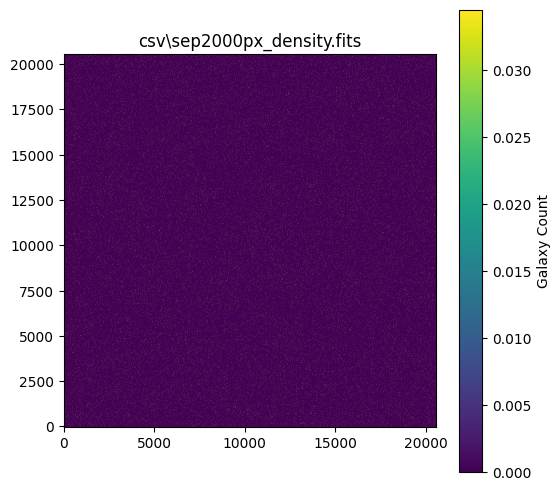

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

fits_path = "csv\sep2000px_density.fits"
data = fits.getdata(fits_path)

plt.figure(figsize=(6,6))
plt.imshow(data, origin='lower', cmap='viridis',
           vmin=np.percentile(data,5),
           vmax=np.percentile(data,99))
plt.colorbar(label='Galaxy Count')
plt.title(fits_path)
plt.show()
